In [ ]:
# fuel poverty spatial

In [2]:
%%capture
!pip install geopandas mapclassify pysal esda

In [5]:
import os

import pandas as pd
import numpy as np

import geopandas as gpd
import pysal as ps
import mapclassify
import esda

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [6]:
from google.colab import drive

Data
==

GDrive mount
--

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [41]:
project_dir = '/content/gdrive/MyDrive/WardProfiles'
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"
fuel_pov_dir = f"{project_dir}/fuel_poverty"

# Outputs
out_dir = f"{project_dir}/fuel_poverty"

In [42]:
!mkdir -p "{out_dir}"

In [43]:
!ls -lh "{oa_dir}"/*lsoa*.gpkg

-rw------- 1 root root 152K Nov  4 17:52 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_200m.gpkg
-rw------- 1 root root 216K Nov  4 17:52 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_20m.gpkg
-rw------- 1 root root 120K Nov  4 17:52 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_centroids.gpkg
-rw------- 1 root root 1.5M Nov  4 17:52 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_full.gpkg


In [44]:
!ls -lh "{ward_dir}"/*.gpkg

-rw------- 1 root root 292K Nov  4 17:52 /content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed.gpkg


In [13]:
!ls -lh "{fuel_pov_dir}" 

Ward & LSOA geometry
--

In [45]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [46]:
# OA geometry
lsoa11 = gpd.read_file(f"{oa_dir}/lbl_lsoa11_20m.gpkg")
len(lsoa11)

169

Fuel poverty data & geometry at LSOA level for Lewisham
==

In [47]:
# fuel poverty data
df = pd.read_csv(f"{fuel_pov_dir}/lbl_fp_lsoa11.csv")
print(len(df))
df.head()

169


,LSOA11CD,LSOA11NM,LAD19CD,LAD19NM,Region,Number of households,Number of households in fuel poverty,Proportion of households fuel poor (%),WD22CD_proposed
0,E01003189,Lewisham 034A,E09000023,Lewisham,London,667,179,26.836582,E05013714
1,E01003190,Lewisham 034B,E09000023,Lewisham,London,861,136,15.795587,E05013714
2,E01003191,Lewisham 034C,E09000023,Lewisham,London,710,161,22.676056,E05013714
3,E01003192,Lewisham 034D,E09000023,Lewisham,London,792,160,20.202020,E05013714
4,E01003193,Lewisham 029A,E09000023,Lewisham,London,711,112,15.752461,E05013729


In [48]:
lsoa_fp_geom = lsoa11.merge(df, on='LSOA11CD')
print(len(lsoa_fp_geom))
lsoa_fp_geom.head()

169


,OBJECTID,LSOA11CD,LSOA11NM_x,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,LSOA11NM_y,LAD19CD,LAD19NM,Region,Number of households,Number of households in fuel poverty,Proportion of households fuel poor (%),WD22CD_proposed
0,3122,E01003189,Lewisham 034A,Lewisham 034A,537582,171828,-0.02233,51.42876,1.885645e+05,2344.244488,"POLYGON ((537627.388 171966.710, 537672.224 17...",Lewisham 034A,E09000023,Lewisham,London,667,179,26.836582,E05013714
1,3123,E01003190,Lewisham 034B,Lewisham 034B,536718,171642,-0.03482,51.42730,3.289821e+05,2927.463701,"POLYGON ((536762.977 172026.305, 536751.439 17...",Lewisham 034B,E09000023,Lewisham,London,861,136,15.795587,E05013714
2,3124,E01003191,Lewisham 034C,Lewisham 034C,537247,171535,-0.02726,51.42621,1.998734e+05,2908.381776,"POLYGON ((537079.289 171863.491, 537091.383 17...",Lewisham 034C,E09000023,Lewisham,London,710,161,22.676056,E05013714
3,3125,E01003192,Lewisham 034D,Lewisham 034D,537962,170926,-0.01722,51.42056,1.018509e+06,5626.055845,"POLYGON ((537479.990 171676.902, 537586.569 17...",Lewisham 034D,E09000023,Lewisham,London,792,160,20.202020,E05013714
4,3126,E01003193,Lewisham 029A,Lewisham 029A,536720,172067,-0.03463,51.43111,3.460524e+05,3569.935721,"POLYGON ((536609.078 172387.938, 536638.293 17...",Lewisham 029A,E09000023,Lewisham,London,711,112,15.752461,E05013729


In [49]:
lsoa_fp_geom.columns

Index(['OBJECTID', 'LSOA11CD', 'LSOA11NM_x', 'LSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry', 'LSOA11NM_y',
       'LAD19CD', 'LAD19NM', 'Region', 'Number of households',
       'Number of households in fuel poverty',
       'Proportion of households fuel poor (%)', 'WD22CD_proposed'],
      dtype='object')

In [59]:
classes = mapclassify.Quantiles(lsoa_fp_geom['Proportion of households fuel poor (%)'], k=5)
classes

Quantiles             

   Interval      Count
----------------------
[ 9.07, 14.28] |    34
(14.28, 16.64] |    34
(16.64, 18.85] |    33
(18.85, 22.52] |    34
(22.52, 31.11] |    34

In [60]:
classes.bins

array([14.27779976, 16.64399413, 18.85485466, 22.51580069, 31.10814419])

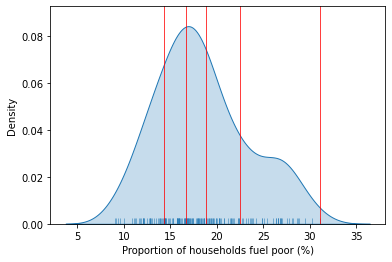

In [61]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(lsoa_fp_geom['Proportion of households fuel poor (%)'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(lsoa_fp_geom['Proportion of households fuel poor (%)'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classes.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

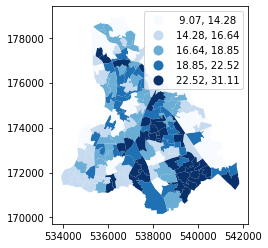

In [62]:
# test
lsoa_fp_geom.plot(column='Proportion of households fuel poor (%)', scheme='quantiles', alpha=1, k=5, \
         cmap=plt.cm.Blues, legend=True)

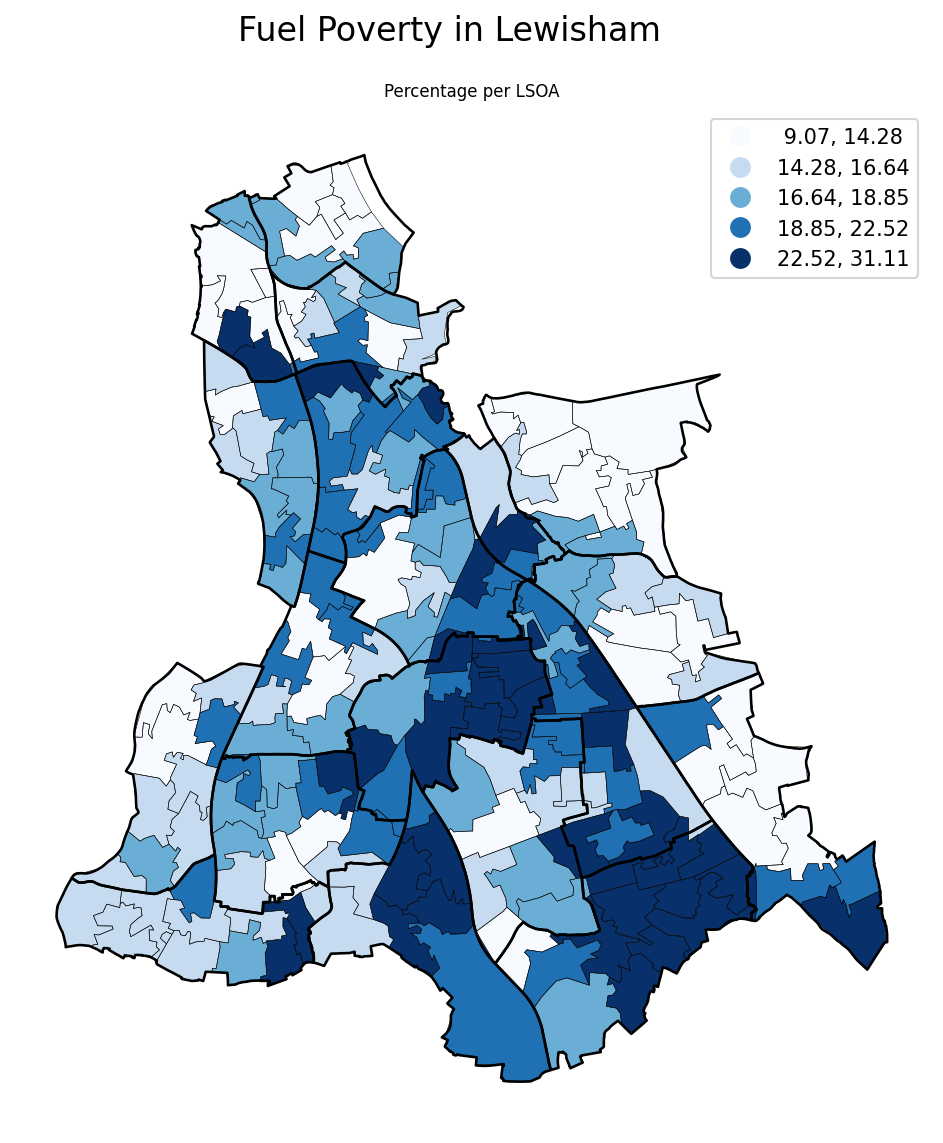

In [63]:
# Plot fuel poverty at LSOAs level
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Fuel Poverty in Lewisham', fontsize=16, y=.95)
plt.title('Percentage per LSOA', fontsize=8)
lsoa_fp_geom.plot(ax=ax, column='Proportion of households fuel poor (%)', scheme='quantiles', alpha=1, k=5, \
         cmap=plt.cm.Blues, legend=True)
lsoa11.plot(ax=ax, facecolor='none', linewidth=0.25, edgecolor='black')
ax.set_axis_off()
wd22.plot(ax=ax, facecolor='none', linewidth=1.25, edgecolor='black')

plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_fp_q5cl.png", dpi=600)
plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_fp_q5cl.pdf")

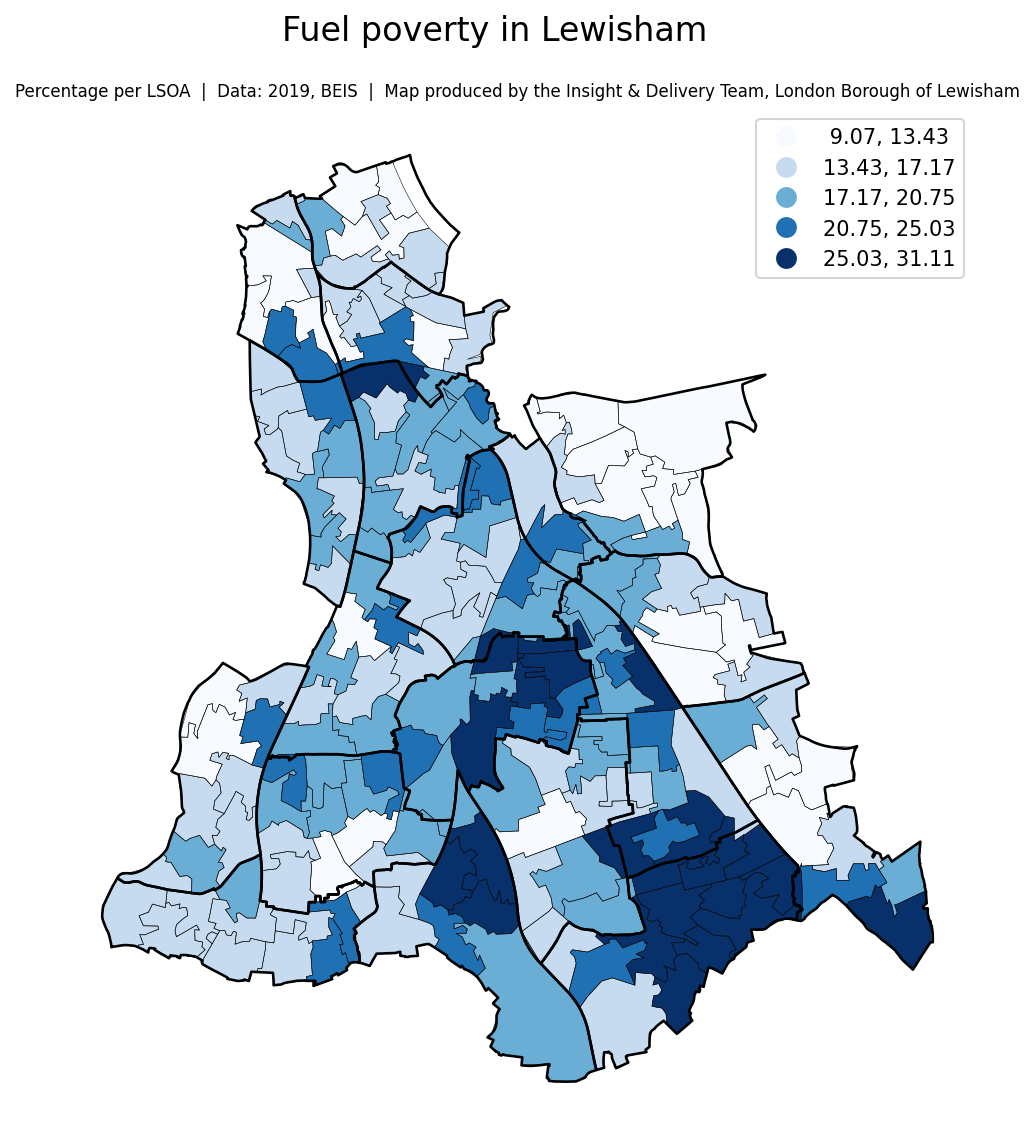

In [64]:
# Plot fuel poverty at LSOAs level
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Fuel poverty in Lewisham', fontsize=16, y=.95)
plt.title('Percentage per LSOA  |  Data: 2019, BEIS  |  Map produced by the Insight & Delivery Team, London Borough of Lewisham', fontsize=8)
lsoa_fp_geom.plot(ax=ax, column='Proportion of households fuel poor (%)', scheme='FisherJenks', alpha=1, k=5, \
         cmap=plt.cm.Blues, legend=True)
lsoa11.plot(ax=ax, facecolor='none', linewidth=0.25, edgecolor='black')
ax.set_axis_off()
wd22.plot(ax=ax, facecolor='none', linewidth=1.25, edgecolor='black')

plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_fp_5cl_fj.png", dpi=600)
plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_fp_5cl_fj.pdf")